### Imports

In [2]:
import pickle
import pandas as pd
from skimage.feature import hog
import numpy as np
from skimage import color, io, exposure, data
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, StratifiedKFold, KFold
import seaborn as sns
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import os
import numpy as np

### Load dataframe and display histogram of ages.

In [3]:
pickle_file_path = './dataframe.pkl'
all_images_path = '../data/processed/all_images/'
with open(pickle_file_path, 'rb') as f:
    initial_df = pickle.load(f)
print(initial_df)

                              name  age  \
0                       000002.jpg   80   
1                       000003.jpg   50   
2                       000004.jpg   17   
3                       000005.jpg   27   
4                       000006.jpg   24   
...                            ...  ...   
26846  9_1_0_20170110224621441.jpg    9   
26847  9_1_0_20170117172655681.jpg    9   
26848  9_1_0_20170117180006484.jpg    9   
26849  9_1_1_20170109201837354.jpg    9   
26850  9_1_1_20170117105556810.jpg    9   

                                            hog_features  
0      [0.3653905268419748, 0.3653905268419748, 0.365...  
1      [0.46159425421679523, 0.46159425421679523, 0.4...  
2      [0.4057592864991771, 0.4057592864991771, 0.405...  
3      [0.43886924277526135, 0.43886924277526135, 0.4...  
4      [0.3956072302348715, 0.3956072302348715, 0.175...  
...                                                  ...  
26846  [0.39953164193287904, 0.39953164193287904, 0.3...  
26847  [0.4

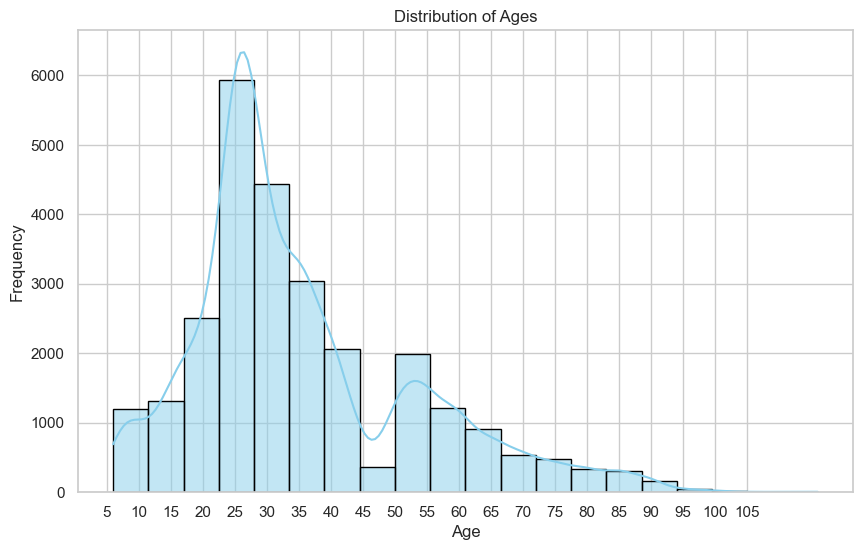

In [4]:
# Set the style for Seaborn (optional)
sns.set(style="whitegrid")

# Create a histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=initial_df, x='age', bins=20, kde=True, color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xticks(range(5, 110, 5))
# Show the plot
plt.show()

Display the HOG feature descriptor for an image.

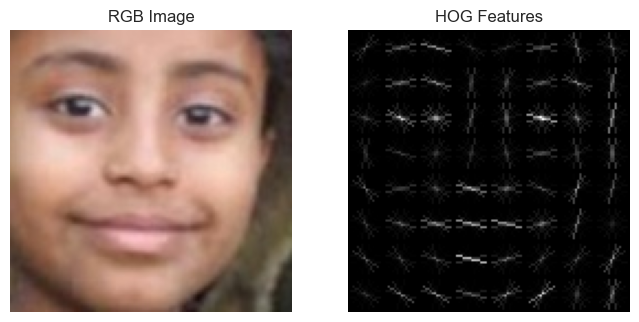

(512,)


In [6]:
from skimage import color, feature, io
import matplotlib.pyplot as plt

# Load an RGB image
image_path = f"{all_images_path}/9_1_1_20170117105556810.jpg"
rgb_image = io.imread(image_path)

# Convert the RGB image to grayscale
gray_image = color.rgb2gray(rgb_image)

# Compute HOG features on the grayscale image
fd, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')

# Display the original RGB image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title('RGB Image')
plt.axis('off')

# Display the HOG features
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.title('HOG Features')
plt.axis('off')

plt.show()
print(fd.shape)

### Create HOG feature vectors for all images, add them to the cached file and then cache it again.

In [5]:
def compute_hog(filename):
    rgb_image = io.imread(f"{all_images_path}/{filename}")
    gray_image = color.rgb2gray(rgb_image)

    fd, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')
    
    return fd

In [90]:
# initial_df['hog_features'] = initial_df['name'].apply(lambda x: compute_hog(x))
# print(initial_df)

                              name  age  \
0                       000002.jpg   80   
1                       000003.jpg   50   
2                       000004.jpg   17   
3                       000005.jpg   27   
4                       000006.jpg   24   
...                            ...  ...   
26846  9_1_0_20170110224621441.jpg    9   
26847  9_1_0_20170117172655681.jpg    9   
26848  9_1_0_20170117180006484.jpg    9   
26849  9_1_1_20170109201837354.jpg    9   
26850  9_1_1_20170117105556810.jpg    9   

                                            hog_features  
0      [0.3653905268419748, 0.3653905268419748, 0.365...  
1      [0.46159425421679523, 0.46159425421679523, 0.4...  
2      [0.4057592864991771, 0.4057592864991771, 0.405...  
3      [0.43886924277526135, 0.43886924277526135, 0.4...  
4      [0.3956072302348715, 0.3956072302348715, 0.175...  
...                                                  ...  
26846  [0.39953164193287904, 0.39953164193287904, 0.3...  
26847  [0.4

In [6]:
with open(pickle_file_path, 'wb') as f:
    pickle.dump(initial_df, f)

with open(pickle_file_path, 'rb') as f:
    hog_df = pickle.load(f)

### Now create the initial splits of train and test (80/20%).

In [4]:
print(f"Median age is: {np.median(initial_df['age'])}")
# Function that gets labels from a json file (need this for both binary and multilabel classification)
def get_class_dict(filename):
    with open(filename, "r") as f:
        class_dict = json.load(f)
    
    return class_dict

# Function that gets the label for an age, given a label dictionary
def get_class(age, class_dict):
    for label, age_interval in class_dict.items():
        if age >= age_interval[0] and age <= age_interval[1]:
            return label

    return -1

Median age is: 30.0


In [8]:
binary_dict = get_class_dict("age_intervals_binary.json")
X = initial_df['age']
y = [get_class(x, binary_dict) for x in initial_df['age']]

splitter = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2, train_size=0.8)
splits = splitter.split(X, y)

for i, (train_index, test_index) in enumerate(splits):
    print(f"    Train: indices={train_index}")
    print(f"    Test: indices={test_index}")

    with open("initial_splits_binary.json", "w") as f:
        fold_data = {"train": train_index.tolist(), "test": test_index.tolist()}
        json.dump(fold_data, f, indent=4)

print(binary_dict)

    Train: indices=[26139  2137 10273 ...  1091  5566 15065]
    Test: indices=[ 9466 25204 24057 ...  5756   637 11775]
{'0': [6, 30], '1': [31, 120]}


Plot that shows how both the test and train split follow the same distribution as the dataset.

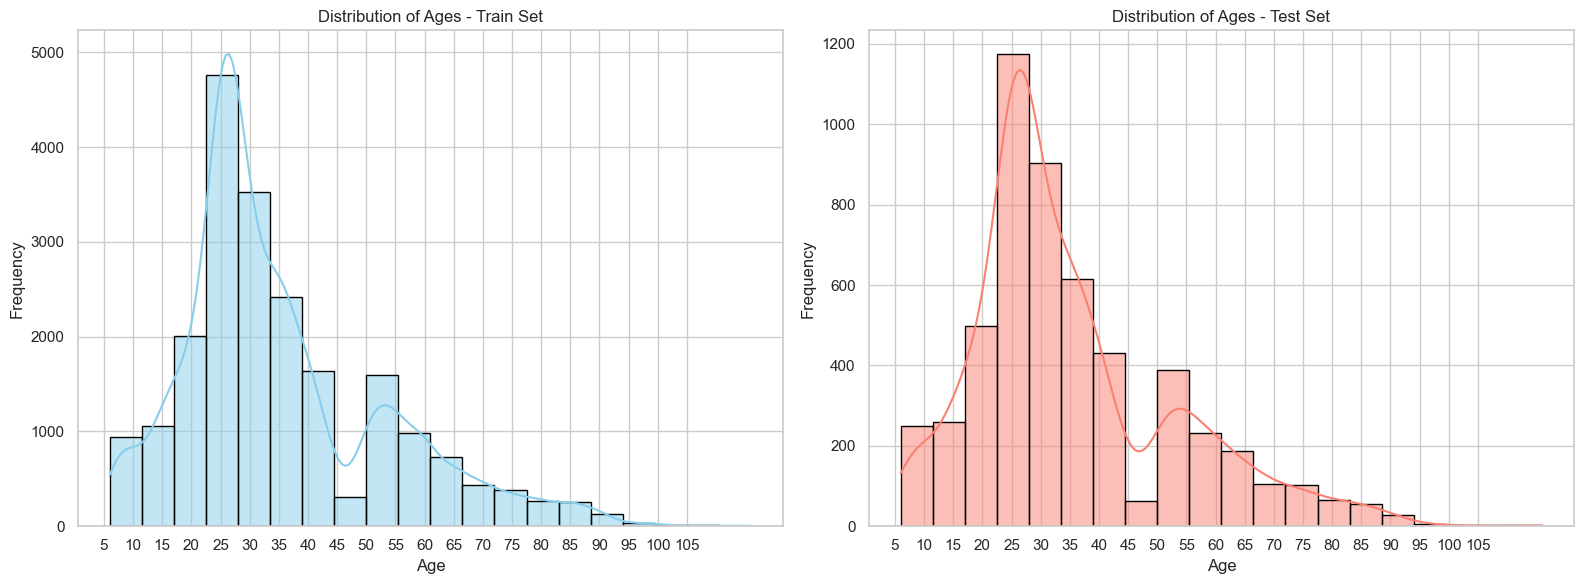

In [8]:
with open("initial_splits_binary.json", "r") as f:
    fold_data = json.load(f)

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.histplot(data=initial_df.loc[fold_data["train"]], x='age', bins=20, kde=True, color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Distribution of Ages - Train Set')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(5, 110, 5))

sns.histplot(data=initial_df.loc[fold_data["test"]], x='age', bins=20, kde=True, color='salmon', edgecolor='black', ax=axes[1])
axes[1].set_title('Distribution of Ages - Test Set')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(range(5, 110, 5))

plt.tight_layout()

plt.show()

### Now onto fitting the binary classifier. I won't do any hyperparameter tuning, as the goal is to move onto a multiclass problem.

In [96]:
X_train = np.vstack(np.array([item for item in hog_df['hog_features']])[fold_data["train"]])
y_train = np.array([get_class(x, binary_dict) for x in hog_df['age']])[fold_data["train"]]

X_test = np.vstack(np.array([item for item in hog_df['hog_features']])[fold_data["test"]])
y_test = np.array([get_class(x, binary_dict) for x in hog_df['age']])[fold_data["test"]]

svm_classifier = LinearSVC(verbose=True, random_state=42)

In [98]:
svm_classifier.fit(X_train, y_train)
predictions = svm_classifier.predict(X_test)
print(classification_report(y_test, predictions))

c:\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[LibLinear]              precision    recall  f1-score   support

           0       0.71      0.71      0.71      2761
           1       0.69      0.69      0.69      2610

    accuracy                           0.70      5371
   macro avg       0.70      0.70      0.70      5371
weighted avg       0.70      0.70      0.70      5371



c:\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Confusion matrix for the binary classifier:

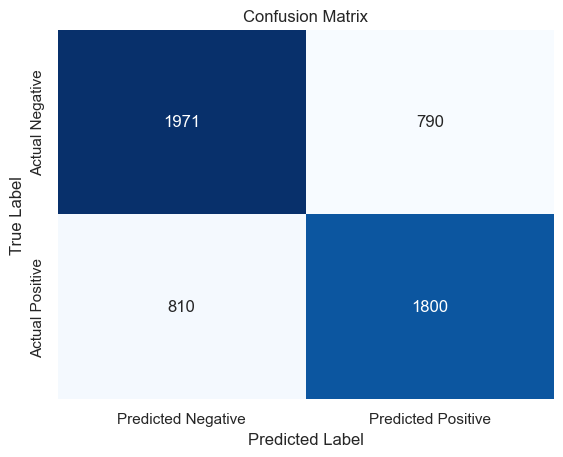

In [102]:
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Now onto the multilabel classification!
We already have the splits.

In [9]:
multilabel_dict = get_class_dict("age_intervals_one.json")
print(multilabel_dict)

X_train = np.vstack(np.array([item for item in hog_df['hog_features']])[fold_data["train"]])
y_train = np.array([get_class(x, multilabel_dict) for x in hog_df['age']])[fold_data["train"]]

X_test = np.vstack(np.array([item for item in hog_df['hog_features']])[fold_data["test"]])
y_test = np.array([get_class(x, multilabel_dict) for x in hog_df['age']])[fold_data["test"]]

{'0': [6, 15], '1': [16, 25], '2': [26, 35], '3': [36, 50], '4': [51, 65], '5': [66, 120]}


### I start with tuning the hyperparameters. The hyperparameters of choice are C value (regularisation constant) and the kernel.
I first split the training set into 5 folds. These 5 fold will be use for cross-validation.
The first parameters I will test for are the kernel and the regularisation constant, C.

In [11]:
os.makedirs('fold_data', exist_ok=True)

In [15]:
kernels = ['rbf', 'linear', 'poly']
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [16]:
all_ages = initial_df['age']
all_labels = [get_class(x, multilabel_dict) for x in initial_df['age']]

all_ages_train = np.array(all_ages)[fold_data['train']]
all_labels_train = np.array(all_labels)[fold_data['train']]
skf_splits = skf.split(all_ages_train, all_labels_train)
root_folder = './fold_data/'

In [137]:
for index, (train_index, val_index) in enumerate(skf_splits):
    filepath = f'{root_folder}fold_{index}.json'
    print(train_index.shape, val_index.shape)
    with open(filepath, 'w') as f:
        json.dump({"train": train_index.tolist(), "val": val_index.tolist()}, f, indent=4)

(17184,) (4296,)
(17184,) (4296,)
(17184,) (4296,)
(17184,) (4296,)
(17184,) (4296,)


In [17]:
train_indices = []
val_indices = []

for i in range(5):
    with open(f"{root_folder}fold_{i}.json") as f:
        fold = json.load(f)
    train_indices.append(fold['train'])
    val_indices.append(fold['val'])


### For the initial hyperparameter tuning step, I will choose the first fold.

In [18]:
tune_indices_train = train_indices[0]
tune_indices_val = val_indices[0]

X_tune_train = np.vstack(np.array([item for item in hog_df['hog_features']])[tune_indices_train])
y_tune_train = np.array([get_class(x, multilabel_dict) for x in hog_df['age']])[tune_indices_train]
X_tune_val = np.vstack(np.array([item for item in hog_df['hog_features']])[tune_indices_val])
y_tune_val = np.array([get_class(x, multilabel_dict) for x in hog_df['age']])[tune_indices_val]

In [175]:
model_folder = './models'
os.makedirs(model_folder, exist_ok=True)

for C in C_values:
    for kernel in kernels:
        svm_classifier = SVC(C=C, kernel=kernel, random_state=42)
        svm_classifier.fit(X_tune_train, y_tune_train)

        predictions = svm_classifier.predict(X_tune_val)
        report = classification_report(y_tune_val, predictions)
        model_name = f'Model_C={C}_kernel={kernel}'
        1
        with open(f"{model_folder}/{model_name}_classification_report.txt", 'w') as f:
            f.write(report)

        with open(f"{model_folder}/{model_name}.pkl", 'wb') as f:
            pickle.dump(svm_classifier, f)

        print(f"Model with C={C} and kernel={kernel} is done training and predicting!")

c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with C=0.001 and kernel=rbf is done training and predicting!


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with C=0.001 and kernel=linear is done training and predicting!


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with C=0.001 and kernel=poly is done training and predicting!


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with C=0.01 and kernel=rbf is done training and predicting!


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with C=0.01 and kernel=linear is done training and predicting!


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with C=0.01 and kernel=poly is done training and predicting!


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with C=0.1 and kernel=rbf is done training and predicting!


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with C=0.1 and kernel=linear is done training and predicting!
Model with C=0.1 and kernel=poly is done training and predicting!


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model with C=1 and kernel=rbf is done training and predicting!
Model with C=1 and kernel=linear is done training and predicting!
Model with C=1 and kernel=poly is done training and predicting!
Model with C=10 and kernel=rbf is done training and predicting!
Model with C=10 and kernel=linear is done training and predicting!
Model with C=10 and kernel=poly is done training and predicting!
Model with C=100 and kernel=rbf is done training and predicting!
Model with C=100 and kernel=linear is done training and predicting!
Model with C=100 and kernel=poly is done training and predicting!
Model with C=1000 and kernel=rbf is done training and predicting!


### Fitting the final 2 models, with C=1000 and kernels in [poly, linear]
The model with kernel='poly' manages to converge after about 30minutes, whereas the one with linear fails to converge. Therefore, I will be dropping these two models as they take too long to converge.

In [20]:
kernels = ['poly', 'linear']
model_folder = './models'
for kernel in kernels:
    svm_classifier = SVC(C=1000, kernel=kernel, random_state=42)
    svm_classifier.fit(X_tune_train, y_tune_train)

    predictions = svm_classifier.predict(X_tune_val)
    report = classification_report(y_tune_val, predictions)
    model_name = f'Model_C=1000_kernel={    kernel}'
    
    with open(f"{model_folder}/{model_name}_classification_report.txt", 'w') as f:
        f.write(report)

    with open(f"{model_folder}/{model_name}.pkl", 'wb') as f:
        pickle.dump(svm_classifier, f)

    print(f"Model with C=1000 and kernel={kernel} is done training and predicting!")


### Now I need to find the best 3 models from the 19 I've fitted, and then do KFold cross validation on these, on the splits that I've created using StratifiedKFold.

In [70]:

def create_models_statistics(model_folder, save_file):
    model_folder = './models'
    all_models_stats_files = [x for x in os.listdir(model_folder) if x.endswith('.txt')]

    all_models_stats = {}
    for idx, filename in enumerate(all_models_stats_files):
        C_value = filename.split('_')[1].split('=')[1]
        kernel = filename.split('_')[2].split('=')[1]

        with open(f"{model_folder}/{filename}", 'r') as f:
            lines = f.readlines()
            labels_info = {}
            for line in lines[2: 8]:
                line_contents = list(map(float, line.strip().split('      ')))
                label = int(line_contents[0])
                precision = line_contents[1]
                recall = line_contents[2]
                f1 = line_contents[3]
                num_features = line_contents[4]
                labels_info[label] = {'precision': precision, 'recall': recall, 'f1': f1, 'num_features': int(num_features)}
            accuracy = float(lines[9].strip().split()[1])
            macro_f1 = float(lines[10].strip().split()[3])
            weighted_f1 = float(lines[11].strip().split()[3])

        all_models_stats[f"Model_{idx}"] = {'C':float(C_value), 'kernel':kernel, 'labels_info':labels_info,
                                            'accuracy':accuracy, 'macro_f1':macro_f1, 'weighted_f1':weighted_f1}

    with open(save_file, 'w') as f:
        json.dump(all_models_stats, f, indent=4)
    
    return all_models_stats

In [71]:
hog_models_stats = create_models_statistics('./models', 'all_hog_models_stats.json')

In [73]:
def drop_incorrect_models(models_dict):
    new_dict = {}
    for model in models_dict:
        model_info = models_dict[model]
        labels_info = models_dict[model]['labels_info']
        invalid = False

        for label in labels_info:
            if labels_info[label]['precision'] == 0.0 or labels_info[label]['recall'] == 0:
                invalid = True
                break
        
        if not invalid:
            new_dict[model] = model_info
    
    return new_dict
        

In [77]:
hog_models_stats = drop_incorrect_models(hog_models_stats)
print(len(hog_models_stats))

10


Now i have only 10 models, that make predictions for all labels. I've discarded those that fail to predict anything for any of the labels. Therefore, It's time to pick the best 3 out of them, and then perform cross-validation with the 5 folds previously created, and then pick the best one. I'll consider the weighted f1 score as the best.

In [84]:
top_3_models = sorted([(x, hog_models_stats[x]['weighted_f1']) for x in hog_models_stats], key=lambda x: x[1], reverse=True)[:3]
print(top_3_models)

[('Model_16', 0.44), ('Model_7', 0.43), ('Model_9', 0.43)]


In [85]:
top_3_models_dict = {x[0]: hog_models_stats[x[0]] for x in top_3_models}
with open('best_3_hog_models.json', 'w') as f:
    json.dump(top_3_models_dict, f, indent=4)

As it can be seen in the best_3_hog_models.json file, the best models are the following: \
C=1.0, kernel=linear \
C=1.0, kernel=poly \
C=1000.0, kernel=rbf

### Now i perform cross-validation for the 3 models.

In [16]:
with open('dataframe.pkl', 'rb') as f:
    hog_df = pickle.load(f)

In [10]:
with open('best_3_hog_models.json') as f:
    best_3_hog_models = json.load(f)

for model in best_3_hog_models:
    model_C = best_3_hog_models[model]['C']
    model_kernel = best_3_hog_models[model]['kernel']
    accuracies = []

    print(f'Fitting for model = {model}')
    for i in tqdm(range(5)):
        svm_classifier = SVC(kernel=model_kernel, C=model_C, random_state=42)
        with open(f'./fold_data/fold_{i}.json') as f:
            fold_data = json.load(f)
        X_fold_train = np.vstack(np.array([item for item in hog_df['hog_features']])[fold_data['train']])
        y_fold_train = np.array([get_class(x, multilabel_dict) for x in hog_df['age']])[fold_data['train']]
        X_fold_val = np.vstack(np.array([item for item in hog_df['hog_features']])[fold_data['val']])
        y_fold_val = np.array([get_class(x, multilabel_dict) for x in hog_df['age']])[fold_data['val']]

        svm_classifier.fit(X_fold_train, y_fold_train)
        predictions = svm_classifier.predict(X_fold_val)

        acc = accuracy_score(y_fold_val, predictions)
        accuracies.append(acc)
    
    best_3_hog_models[model]['accuracy_CV'] = np.mean(accuracies)
    print(f'CV Accuracy for model {model} is {np.mean(accuracies)}')



Fitting for model = Model_16


100%|██████████| 5/5 [13:17<00:00, 159.56s/it]


CV Accuracy for model Model_16 is 0.4405959031657356
Fitting for model = Model_7


100%|██████████| 5/5 [18:00<00:00, 216.04s/it]


CV Accuracy for model Model_7 is 0.44259776536312856
Fitting for model = Model_9


100%|██████████| 5/5 [1:03:33<00:00, 762.63s/it]

CV Accuracy for model Model_9 is 0.4362662942271881


In [14]:
with open('best_3_hog_models.json', 'w') as f:
    json.dump(best_3_hog_models, f, indent=4)

In [27]:
best_hog_model = sorted([(model, best_3_hog_models[model]['accuracy_CV']) for model in best_3_hog_models], key=lambda x: x[1], reverse=True)[0][0]
best_hog_model = best_3_hog_models[best_hog_model]

with open('best_hog_model.json', 'w') as f:
    json.dump(best_hog_model, f, indent=4)

### I found the best HOG model. It has C = 0.1 and the kernel is polynomial.
Time to train it on the initial training set and then test it against the test set, which is unseen.

In [43]:
with open('initial_splits_binary.json', 'r') as f:
    fold_data = json.load(f)

X_train = np.vstack(np.array([item for item in hog_df['hog_features']])[fold_data['train']])
y_train = np.array([get_class(x, multilabel_dict) for x in hog_df['age']])[fold_data['train']]
X_test = np.vstack(np.array([item for item in hog_df['hog_features']])[fold_data['test']])
y_test = np.array([get_class(x, multilabel_dict) for x in hog_df['age']])[fold_data['test']]

In [44]:
svm_classifier = SVC(C=best_hog_model['C'], kernel=best_hog_model['kernel'], random_state=42)
svm_classifier.fit(X_train, y_train)
predictions = svm_classifier.predict(X_test)
acc = accuracy_score(y_test, predictions)

print(f'Final test accuracy is {acc}')

Final test accuracy is 0.40811766896294915


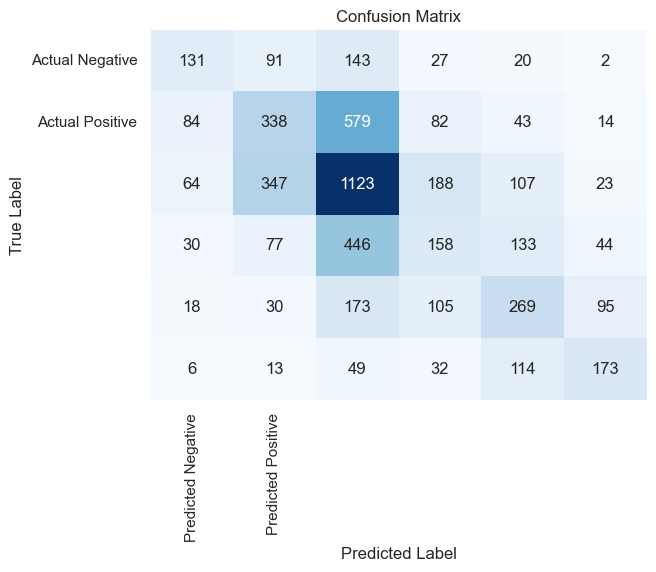

In [50]:
cm = confusion_matrix(y_test, predictions)
labels = [str(x).replace('[', '').replace(']','').replace(', ', '-') for x in multilabel_dict.values()]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()